**Importing Libraries**

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from hyperopt import hp, tpe, STATUS_OK, Trials, fmin

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import shap

import pickle

import warnings
warnings.filterwarnings('ignore')

**Reading the data**

In [3]:
df = pd.read_csv('data/processed/processed_data.csv')

df.head()

,has_https,url_len,domain_len,path_len,query_len,url_depth,subdomain_count,tld_len,url_has_ipv4,url_has_port,...,spl_char_count,url_entropy,domain_entropy,sld_entropy,path_entropy,domain_token_count,path_token_count,total_tokens,avg_token_length,class
0,1,25,10,6,0,1,1,2,0,0,...,5,3.863465,2.721928,2.235926,2.521641,2,1,3,5.00,1
1,1,37,22,6,0,1,1,3,0,0,...,5,4.208925,3.629220,3.419382,2.521641,2,1,3,9.00,1
2,1,32,18,5,0,1,1,3,0,0,...,6,4.452820,3.947703,3.000000,2.584963,3,1,4,5.25,1
3,1,46,14,0,22,1,1,3,0,0,...,7,4.760096,3.664498,3.121928,-0.000000,2,1,3,8.50,1
4,1,32,18,5,0,1,1,3,0,0,...,6,4.241729,3.836592,3.000000,2.584963,3,1,4,5.25,1


**Splitting the data**

In [4]:
X = df.drop(columns=['class']).values
y = df['class'].values

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=6)

**Training the Models**

In [6]:
# Function to evaluate the models
def evaluate_model(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')

*Random Forest Classifier*

In [7]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

print('Metrics of Random Forest on Training data:')
evaluate_model(y_train,rf_pred_train)

print()

print('Metrics of Random Forest on Testing data:')
evaluate_model(y_test,rf_pred_test)

Metrics of Random Forest on Training data:
Accuracy: 0.9980076354092102
Precision: 0.99923558711841
Recall: 0.9966551071103569
F1-Score: 0.997943678967653

Metrics of Random Forest on Testing data:
Accuracy: 0.9792412312097352
Precision: 0.9878127247265432
Recall: 0.9688903738352452
F1-Score: 0.9782600547246898


*XGBoost Classifier*

In [8]:
xg_model = XGBClassifier()
xg_model.fit(X_train,y_train)

xg_pred_train = xg_model.predict(X_train)
xg_pred_test = xg_model.predict(X_test)

print('Metrics of XGBoost Classifier on Training data:')
evaluate_model(y_train,xg_pred_train)

print()

print('Metrics of XGBoost Classifier on Testing data:')
evaluate_model(y_test,xg_pred_test)

Metrics of XGBoost Classifier on Training data:
Accuracy: 0.9858088761632069
Precision: 0.9963655570506935
Recall: 0.974298433311198
F1-Score: 0.9852084434358194

Metrics of XGBoost Classifier on Testing data:
Accuracy: 0.9825518969219756
Precision: 0.9934615677031856
Recall: 0.9701897018970189
F1-Score: 0.9816877335987829


By comparing the metrics of Random Forest Classifier & XGBoost Classifier on both training set and testing set, XGBoost Classifier is best. Both the model's metrics are good on training set but on testing set, Random Forest model's metrics are slightly lower than XGBoost model's metrics telling that Random Forest model has less Generalization. Therefore, we prefer XGBoost Classifier.

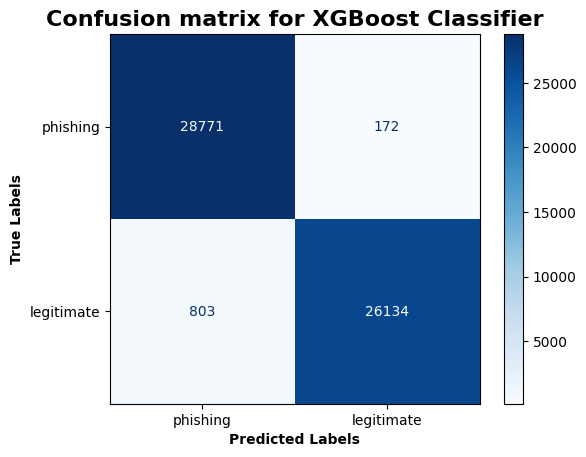

In [9]:
disp = ConfusionMatrixDisplay.from_estimator(xg_model,X_test,y_test,display_labels=['phishing','legitimate'],cmap=plt.cm.Blues)
plt.xlabel('Predicted Labels',weight='bold')
plt.ylabel('True Labels',weight='bold')
plt.title('Confusion matrix for XGBoost Classifier',weight='bold',fontsize=16)
plt.show()

**Feature Importance**

In [10]:
features = df.drop(columns='class').columns
explainer = shap.TreeExplainer(xg_model)
shap_values = explainer.shap_values(X_test)

shap.initjs()

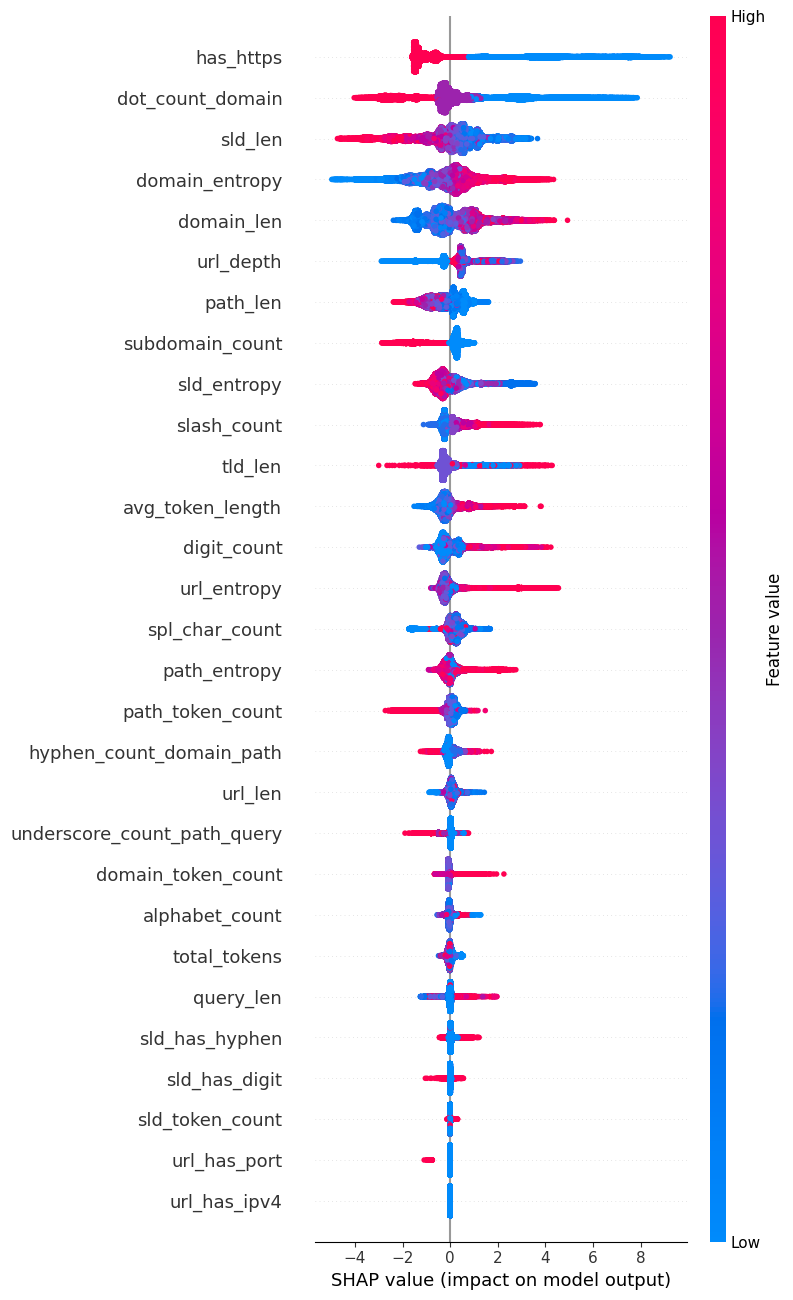

In [11]:
X_test_df = pd.DataFrame(X_test,columns=features)
shap.summary_plot(shap_values,X_test_df,max_display=30)

From the above plot, most of the features have some impact in predicting phishing URLs. But there are some features which does not show any impact on predictions: 
- total_tokens
- sld_token_count 
- url_has_ipv4
- url_has_port

So, we will ignore these features.

Therefore the final features considered to train the model are:
- has_https
- url_len
- domain_len
- path_len
- query_len
- url_depth
- subdomain_count
- tld_len
- sld_len
- sld_has_digit
- sld_has_hyphen
- dot_count_domain
- hyphen_count_domain_path
- underscore_count_path_query
- slash_count
- digit_count
- alphabet_count
- spl_char_count
- url_entropy
- domain_entropy
- sld_entropy
- path_entropy
- domain_token_count
- path_token_count
- avg_token_length

In [12]:
# Updated data
updated_df = df.drop(columns=['total_tokens','sld_token_count','url_has_ipv4','url_has_port'])

X_updated = updated_df.drop(columns='class').values
y_updated = updated_df['class']

X_train_updated,X_test_updated,y_train_updated,y_test_updated = train_test_split(X_updated,y_updated,train_size=0.75,random_state=6)

In [13]:
# Saving the updated data
updated_df.to_csv('data/feature_refined/feature_refined_data.csv',index=False)
print('Updated data saved')

Updated data saved


In [14]:
model = XGBClassifier()
model.fit(X_train_updated,y_train_updated)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [15]:
print('Metrics of XGBoost Classifier on Training data:')
evaluate_model(y_train_updated,model.predict(X_train_updated))

print()

print('Metrics of XGBoost Classifier on Testing data:')
evaluate_model(y_test_updated,model.predict(X_test_updated))

Metrics of XGBoost Classifier on Training data:
Accuracy: 0.9859520400858983
Precision: 0.9962169295544523
Recall: 0.9747411397230625
F1-Score: 0.9853620332788424

Metrics of XGBoost Classifier on Testing data:
Accuracy: 0.9828203292770222
Precision: 0.9936528448177568
Recall: 0.9705609384860971
F1-Score: 0.9819711538461539


**Hyperparameter Tuning**

In [16]:
search_space = {
    "max_depth" : hp.quniform("max_depth",3,10,1),
    "learning_rate" : hp.loguniform("learning_rate",np.log(0.01),np.log(0.2)),
    "n_estimators" : hp.quniform("n_estimators",100,600,50),
    "subsample" : hp.uniform("subsample",0.6,1.0),
    "colsample_bytree" : hp.uniform("colsample_bytree",0.6,1.0),
    "gamma" : hp.uniform("gamma",0,5),
    "min_child_weight" : hp.qloguniform("min_child_weight",1,10,1),
    "reg_alpha" : hp.loguniform("reg_alpha",np.log(1e-3),np.log(1)),
    "reg_lambda" : hp.loguniform("reg_lambda",np.log(1),np.log(10))
}

In [17]:
def objective(params):

    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])

    params.update({
        "objective" : "binary:logistic",
        "eval_metric" : "logloss",
        "random_state" : 42,
        "tree_method" : "hist",
        "n_jobs" : -1
    })

    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

    recalls = []

    for train_idx,val_idx in skf.split(X_train,y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = XGBClassifier(**params)
        model.fit(X_tr,y_tr)

        y_pred = model.predict(X_val)
        recalls.append(recall_score(y_val, y_pred))

    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)

    return {"loss" : -mean_recall, "status" : STATUS_OK}

In [18]:
trials = Trials()

best_params = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = trials
)

100%|██████████| 50/50 [04:07<00:00,  4.96s/trial, best loss: -0.9702648921764627]


In [19]:
best_params

{'colsample_bytree': 0.6467775791690556,
 'gamma': 1.1327649937229542,
 'learning_rate': 0.19739238497749395,
 'max_depth': 6.0,
 'min_child_weight': 3.0,
 'n_estimators': 300.0,
 'reg_alpha': 0.05223219666480833,
 'reg_lambda': 2.2337823495400113,
 'subsample': 0.6033832013130304}

In [20]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

best_params.update({
    'objective' : 'binary:logistic',
    'eval_metric' : 'logloss',
    'random_state' : 42,
    'n_jobs' : -1
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train,y_train)

print('Metrics of XGBoost Classifier on Training data:')
evaluate_model(y_train,final_model.predict(X_train))

print()

print('Metrics of XGBoost Classifier on Testing data:')
evaluate_model(y_test,final_model.predict(X_test))

Metrics of XGBoost Classifier on Training data:
Accuracy: 0.9871391076115485
Precision: 0.9960149377177373
Recall: 0.9773973781942498
F1-Score: 0.9866183370987364

Metrics of XGBoost Classifier on Testing data:
Accuracy: 0.9824087329992842
Precision: 0.9920376128004853
Recall: 0.9713034116642536
F1-Score: 0.9815610286807601


**Handling False Negatives**

In [30]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

def recall_and_threshold_constrained_selection(
    y_true,
    y_prob,
    min_recall=0.9725,
    min_threshold=0.45
):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # precision_recall_curve returns one extra precision/recall value
    precision = precision[:-1]
    recall = recall[:-1]

    thresholds = np.array(thresholds)

    # Apply BOTH constraints
    valid_idxs = np.where(
        (recall >= min_recall) &
        (thresholds >= min_threshold)
    )[0]

    if len(valid_idxs) == 0:
        raise ValueError(
            f"No threshold satisfies recall >= {min_recall} "
            f"and threshold >= {min_threshold}"
        )

    # Among valid thresholds, maximize precision
    best_idx = valid_idxs[np.argmax(precision[valid_idxs])]
    best_threshold = thresholds[best_idx]

    return {
        "threshold": float(best_threshold),
        "precision": float(precision[best_idx]),
        "recall": float(recall[best_idx]),
        "f1": float(
            f1_score(
                y_true,
                (y_prob >= best_threshold).astype(int)
            )
        ),
        "accuracy": accuracy_score(
                y_true,
                (y_prob >= best_threshold).astype(int)
            )
    }

In [22]:
y_prob = final_model.predict_proba(X_test)[:,1]
y_prob

array([0.9997161 , 0.00365725, 0.02950696, ..., 0.99990857, 0.9999615 ,
       0.99667823], shape=(55880,), dtype=float32)

In [31]:
recall_and_threshold_constrained_selection(y_test,y_prob)

{'threshold': 0.46429693698883057,
 'precision': 0.9904347826086957,
 'recall': 0.9725284924082117,
 'f1': 0.9813999662839268,
 'accuracy': 0.9822297780959198}

After applying a recall-constrined threshold (≥ 0.45) slightly increased recall to 0.9725 while maintaining very high precision (0.9904), resulting in a unchanged F1-score (0.9821) and accuracy (0.9822) compared to the initial model. Now the threshold is 0.464.

**Saving the model**

In [32]:
with open('models/XGBoostModel.pkl','wb') as file:
    pickle.dump(final_model,file=file)